In [42]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
import cerberus
import pyranges as pr

p = os.path.dirname(os.getcwd())
sys.path.append(p)

# from scripts.utils import *
# from scripts.vcf_utils import *
# from scripts.plotting import *

In [43]:
import seaborn as sns
import matplotlib as mpl

def rm_color_cats(c_dict, order, cats):
    if cats:
        keys = c_dict.keys()
        pop_list = []
        for key in keys:
            if key not in cats:
                pop_list.append(key)
        for p in pop_list:
            del c_dict[p]
        order = [o for o in order if o in cats]
    return c_dict, order

def get_talon_nov_colors(cats=None):
    c_dict = {'Known': '#009E73',
              'ISM': '#0072B2',
              'ISM_rescue': '#0072B2',
              'NIC': '#D55E00',
              'NNC': '#E69F00',
              'Antisense': '#000000',
              'Intergenic': '#CC79A7',
              'Genomic': '#F0E442'}
    order = ['Known', 'ISM', 'ISM_rescue', 'NIC', 'NNC', 'Antisense', 'Intergenic', 'Genomic']

    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

def get_pop_colors():
    c_dict = {'AJI': '#46bff0',
            'HAC': '#4cb33e',
            'ITU': '#db72f2',
            'LWK': '#A09136',
            'MPC': '#eb9d0c',
            'PEL': '#ff3a33',
            'YRI': '#DFBD00',
            'CEU': '#347eed'}
    return c_dict, list(c_dict.keys())


def init_plot_settings(font_scale=2,
                       aspect='square',
                       subplot_r=None,
                       subplot_c=None,
                       w=None,
                       h=None):
    """
    Initialize default plotting settings
    """
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42

    if aspect=='square':
        mpl.rcParams['figure.figsize'] = (5,5)
    elif aspect=='rectangle':
        mpl.rcParams['figure.figsize'] = (7,5)
    
    if w and h:
        mpl.rcParams['figure.figsize'] = (w,h)
    if subplot_r and subplot_c:
        mpl.rcParams['figure.figsize'] = (5*subplot_c, 5*subplot_r)
    

## Fix gene annots

In [44]:
ca = cerberus.read('merged.h5')

df = ca.t_map.copy(deep=True)
ic_df = ca.ic.copy(deep=True)
ic_df.rename({'Name':'ic_id'}, axis=1, inplace=True)
df = df.merge(ic_df[['ic_id', 'novelty']], 
              on='ic_id', 
              how='left')
del ca

# reannotate novel genes novelty
df.loc[df.gene_id.str.contains('novel'), 'novelty'] = 'Intergenic'

# get sample
df['sample'] = df.source.str.split('_', expand=True)[0]

# get population info
meta = pd.read_csv('pantranscriptome_samples_metadata.tsv', sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))

1502903
1502903
1502903
1502903


In [45]:
df.head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source,novelty,sample,population
0,ENST00000797504.1,16,ENSG00000303853_16,ENSG00000303853_5,5,ENSG00000303853_5,5,ENSG00000303853,ENSG00000303853,ENST00000797504.1,"[5,16,5]","ENSG00000303853[5,16,5]","ENSG00000303853[5,16,5]",False,False,GM19117_1,Known,GM19117,YRI
1,ENST00000797522.1,10,ENSG00000303853_10,ENSG00000303853_2,2,ENSG00000303853_8,8,ENSG00000303853,ENSG00000303853,ENST00000797522.1,"[2,10,8]","ENSG00000303853[2,10,8]","ENSG00000303853[2,10,8]",False,False,GM19117_1,Known,GM19117,YRI
2,ENST00000832168.1,85,ENSG00000308185_85,ENSG00000308185_1,1,ENSG00000308185_16,16,ENSG00000308185,ENSG00000308185,ENST00000832168.1,"[1,85,16]","ENSG00000308185[1,85,16]","ENSG00000308185[1,85,16]",False,False,GM19117_1,Known,GM19117,YRI
3,ENST00000832246.1,91,ENSG00000308185_91,ENSG00000308185_1,1,ENSG00000308185_9,9,ENSG00000308185,ENSG00000308185,ENST00000832246.1,"[1,91,9]","ENSG00000308185[1,91,9]","ENSG00000308185[1,91,9]",False,False,GM19117_1,Known,GM19117,YRI
4,ENST00000832252.1,66,ENSG00000308185_66,ENSG00000308185_1,1,ENSG00000308185_31,31,ENSG00000308185,ENSG00000308185,ENST00000832252.1,"[1,66,31]","ENSG00000308185[1,66,31]","ENSG00000308185[1,66,31]",False,False,GM19117_1,Known,GM19117,YRI


In [46]:
c_dict, order = get_pop_colors()

In [47]:
# count of # samples in a population that have each transcript
temp = df.groupby(['transcript_id', 'novelty', 'population']).nunique().reset_index().rename({'sample':'n_samples'}, axis=1)
temp.loc[temp.n_samples>1]

,transcript_id,novelty,population,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source,n_samples
2,"ENSG00000000003[1,1,1]",Known,HAC,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4
4,"ENSG00000000003[1,1,1]",Known,LWK,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2
5,"ENSG00000000003[1,1,1]",Known,MPC,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4
6,"ENSG00000000003[1,1,1]",Known,PEL,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4
7,"ENSG00000000003[1,1,1]",Known,YRI,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490364,"novel_gene_999gene999[1,1,1]",Intergenic,YRI,2,1,1,1,1,1,1,1,1,2,1,1,1,1,2,2
490368,"novel_gene_9gene9[1,1,1]",Intergenic,CEU,3,1,1,1,1,1,1,1,1,3,1,1,1,1,3,3
490370,"novel_gene_9gene9[1,1,1]",Intergenic,ITU,2,1,1,1,1,1,1,1,1,2,1,1,1,1,2,2
490371,"novel_gene_9gene9[1,1,1]",Intergenic,MPC,2,1,1,1,1,1,1,1,1,2,1,1,1,1,2,2


In [48]:
# count of # of ICs that have n number of samples
temp2 = temp.groupby(['n_samples', 'novelty', 'population']).nunique().reset_index().rename({'Name':'n_ics'}, axis=1)

In [49]:
# make these plots, then adjust max values
init_plot_settings(subplot_r=len(temp.population.unique()),
                   subplot_c=len(temp.novelty.unique()))
# temp2 = temp.loc[(temp.novelty=='ISM')&(temp.population=='AJI')]
# g = sns.FacetGrid(temp, col='population', row='novelty')
# g.map(sns.barplot, temp,
#             'n_samples',
#             'n_ics')
#             # saturation=1,
#             # col='population',
#             # row='novelty',
#             # hue='population',
#             # palette=c_dict)
# sns.catplot(temp2,
#             kind='bar',
#             x='n_samples',
#             y='n_ics',
#             saturation=1,
#             col='population',
#             row='novelty',
#             sharey='row')

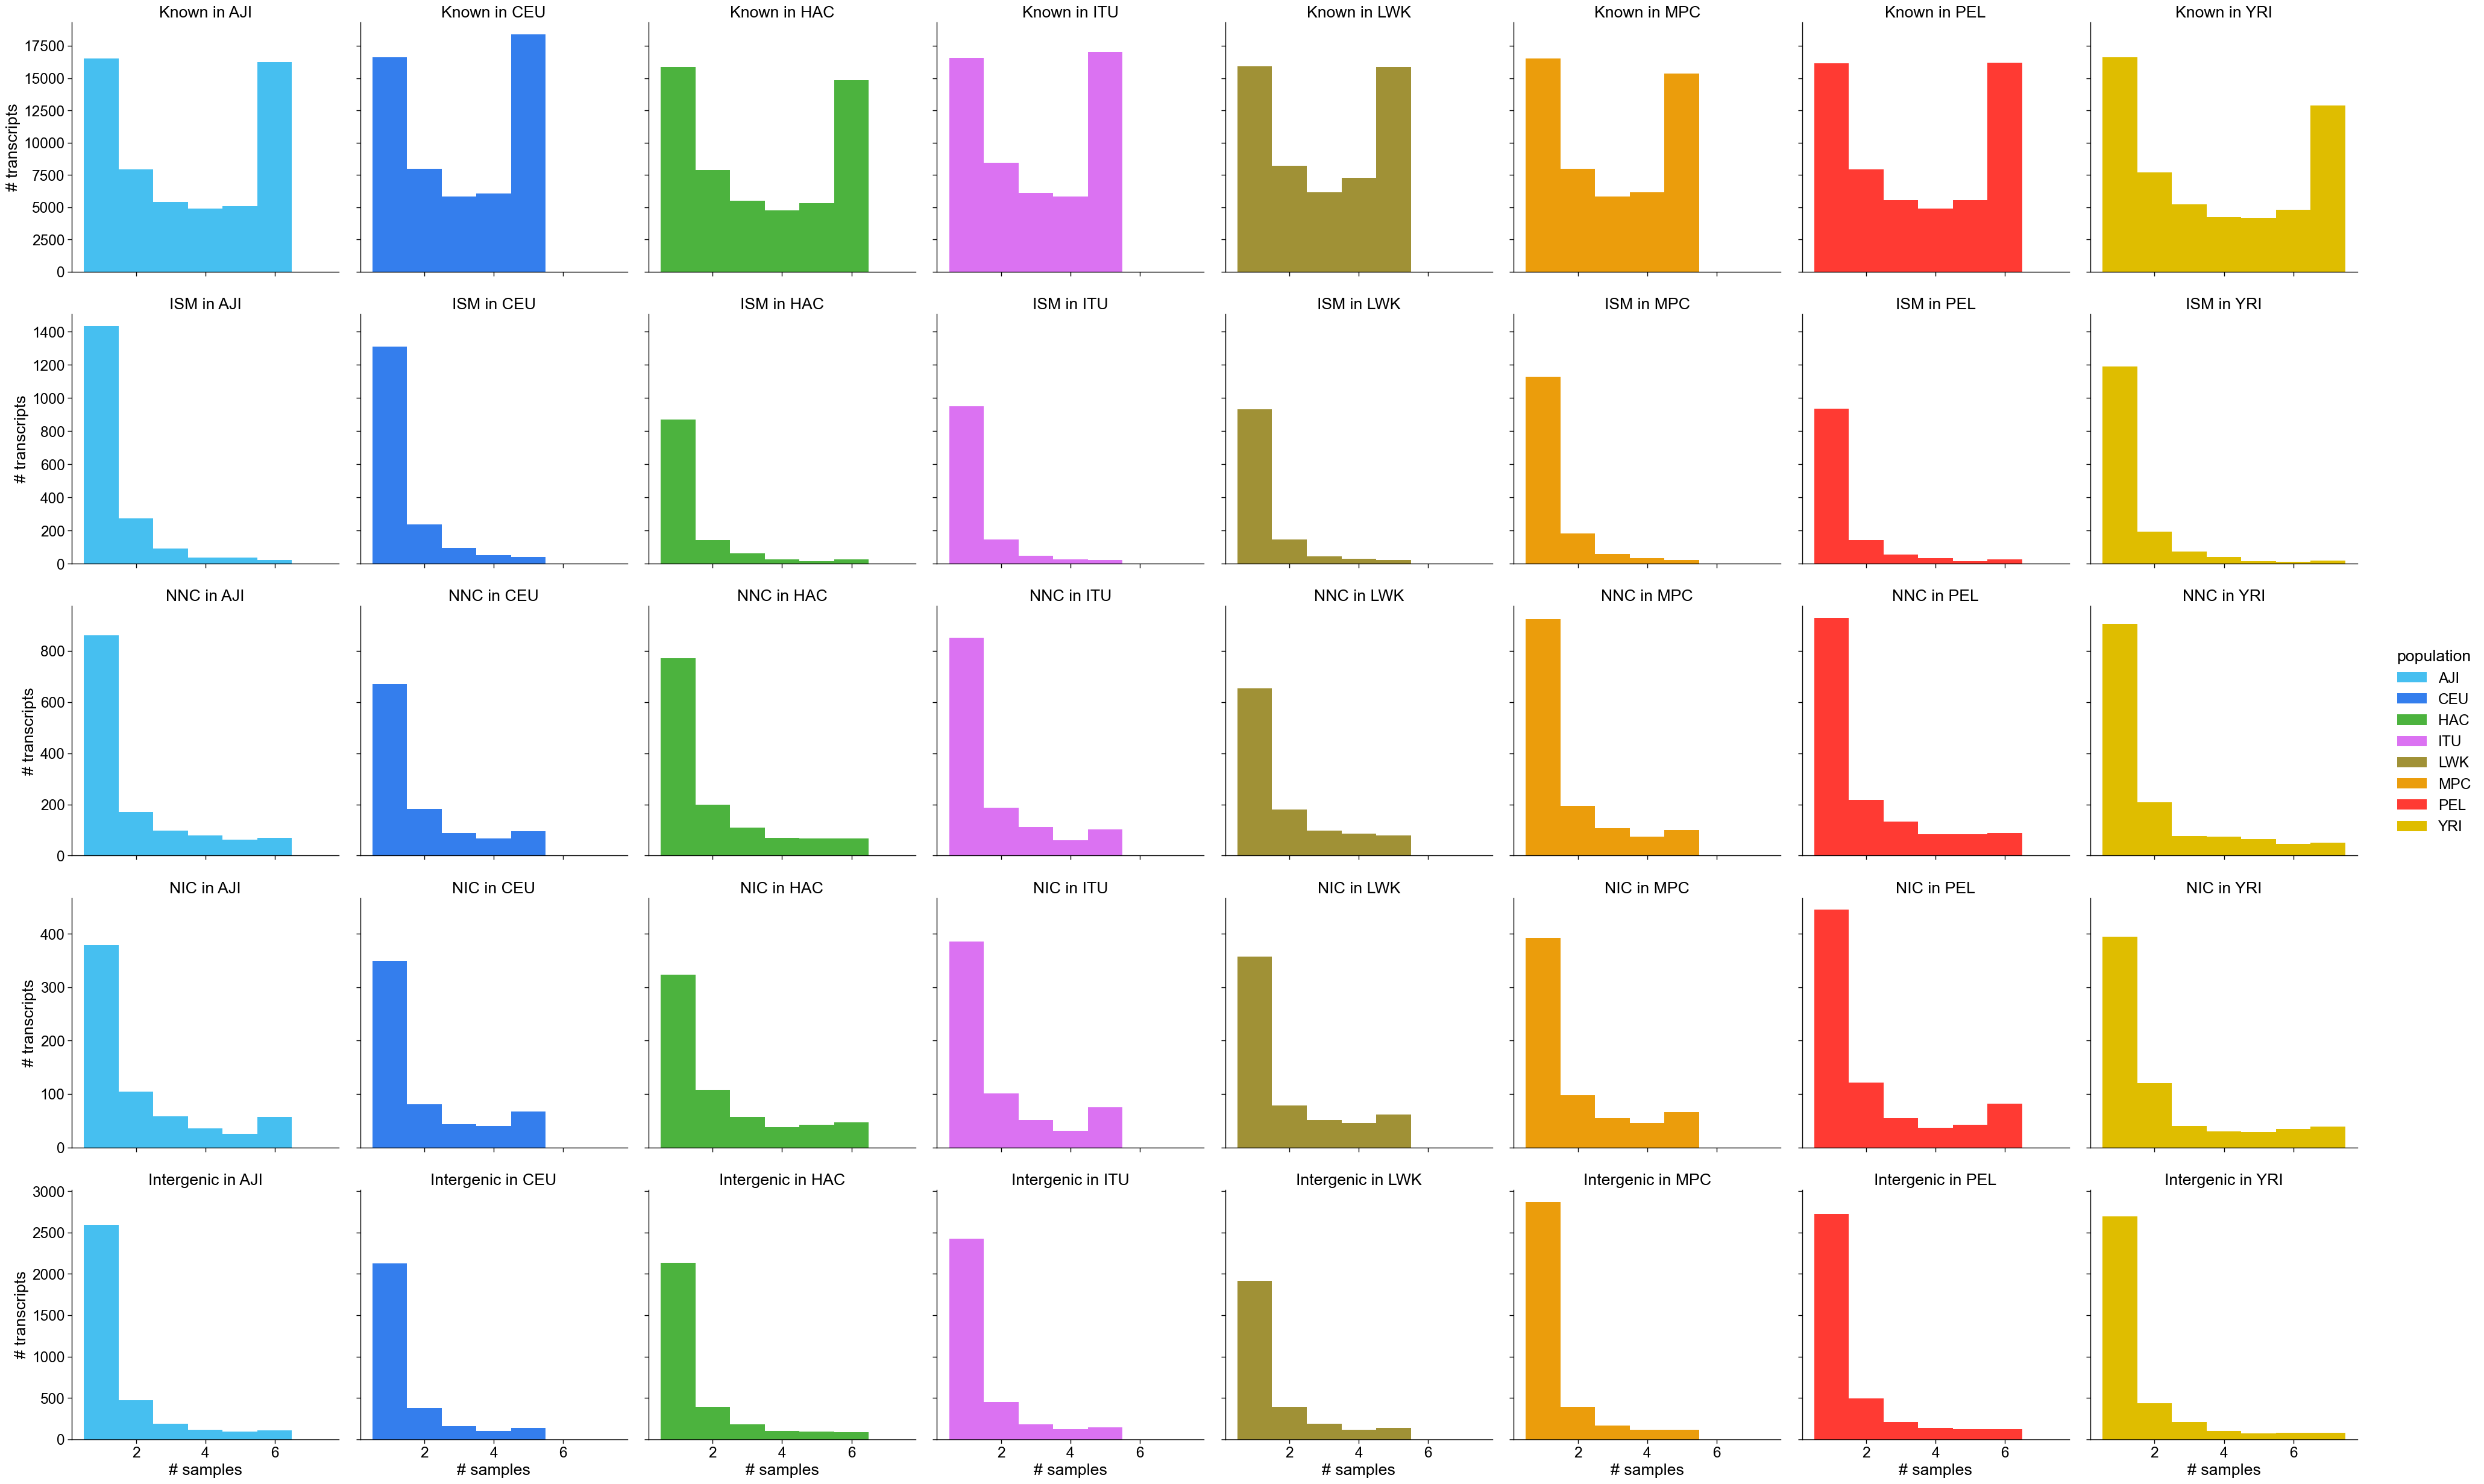

In [50]:

c_dict, order = get_pop_colors()
init_plot_settings(font_scale=3)
g = sns.displot(temp,
            kind='hist',
            x='n_samples',
            alpha=1,
            discrete=True,
            col='population',
            row='novelty',
            edgecolor=None,
            hue='population',
            palette=c_dict,
            facet_kws=dict(sharey='row'))
g.set_axis_labels('# samples', '# transcripts')
g.set_titles('{row_name} in {col_name}')

## Global summary statistics of IC reproducibility per novelty cat

In [51]:
c_dict, order = get_talon_nov_colors(cats=df.novelty.unique().tolist())

In [52]:
ca = cerberus.read('merged.h5')

df = ca.t_map.copy(deep=True)
ic_df = ca.ic.copy(deep=True)
ic_df.rename({'Name':'ic_id'}, axis=1, inplace=True)
df = df.merge(ic_df[['ic_id', 'novelty']], 
              on='ic_id', 
              how='left')
del ca

# reannotate novel genes novelty
df.loc[df.gene_id.str.contains('novel'), 'novelty'] = 'Intergenic'

# get sample
df['sample'] = df.source.str.split('_', expand=True)[0]

# get population info
meta = pd.read_csv('pantranscriptome_samples_metadata.tsv', sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))

1502903
1502903
1502903
1502903


In [53]:
# get the number of samples each ic is in
df = df[['transcript_id', 'novelty', 'sample']].groupby(['transcript_id', 'novelty']).nunique().rename({'sample':'n_samples'}, axis=1).reset_index()
# df = df.groupby(['novelty', 'n_samples']).nunique().rename({'Name':'n_ics'}, axis=1).reset_index()

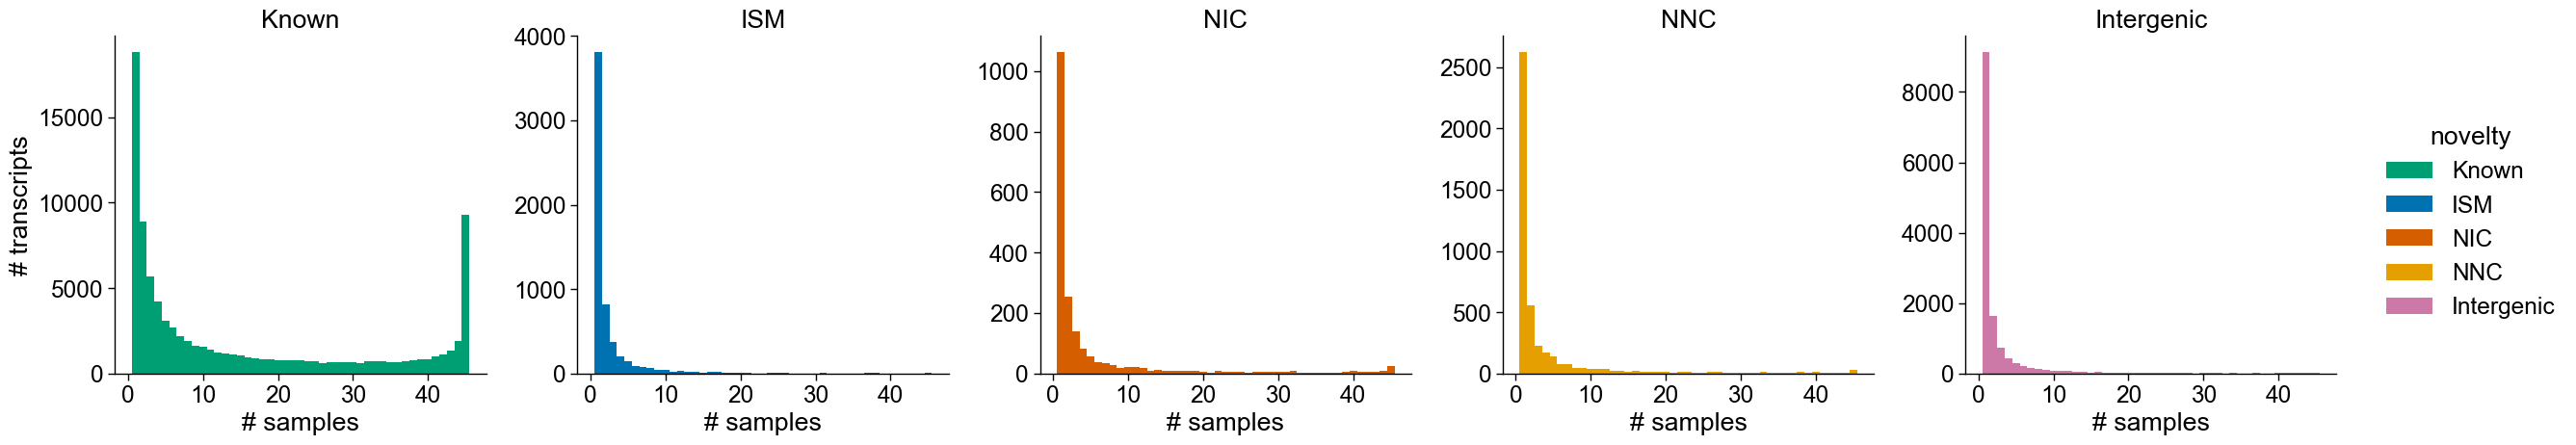

In [54]:
init_plot_settings(font_scale=2)
g = sns.displot(df,
            kind='hist',
            x='n_samples',
            alpha=1,
            discrete=True,
            col='novelty',
            col_order=order,
            hue_order=order,
            edgecolor=None,
            hue='novelty',
            palette=c_dict,
            facet_kws=dict(sharey='col'))
g.set_axis_labels('# samples', '# transcripts')
g.set_titles('{col_name}')

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_18037/1248428974.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(temp, x='novelty', palette=c_dict, order=order, y='perc', saturation=1)


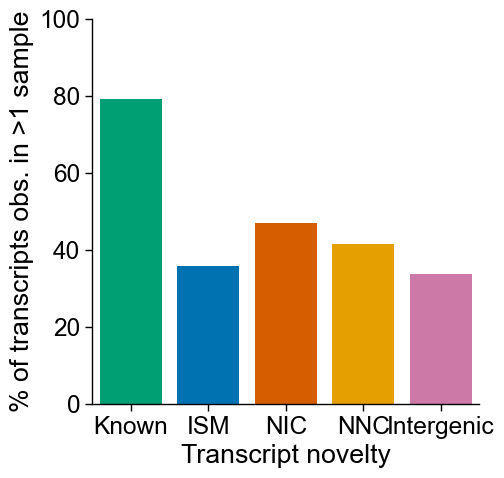

In [55]:
# what % of each category is unique to one sample?
temp = df.groupby(['novelty', 'n_samples']).nunique().rename({'transcript_id':'n_ics'}, axis=1).reset_index()
temp['multiple_samples'] = temp.n_samples>1
temp = temp[['novelty', 'multiple_samples', 'n_ics']].groupby(['novelty', 'multiple_samples']).sum().reset_index()
temp['total_ics'] = temp.groupby('novelty')['n_ics'].transform('sum')

temp['perc'] = (temp.n_ics/temp.total_ics)*100

temp = temp.loc[temp.multiple_samples==True]
ax = sns.barplot(temp, x='novelty', palette=c_dict, order=order, y='perc', saturation=1)
xlabel = 'Transcript novelty'
ylabel = '% of transcripts obs. in >1 sample'
_ = ax.set(xlabel=xlabel, ylabel=ylabel, ylim=(0,100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_18037/722170889.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(temp, x='novelty', palette=c_dict, order=order, y='perc', saturation=1)


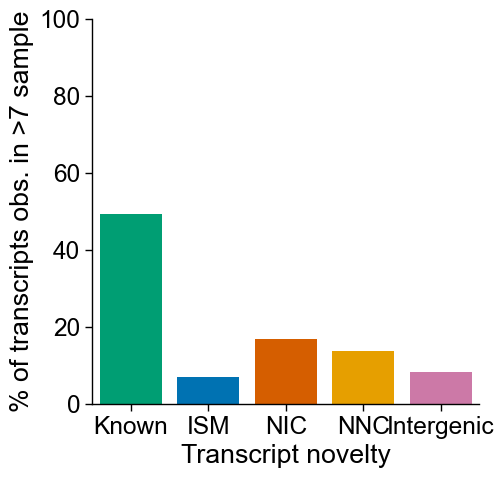

In [56]:
# what % of each category is unique to one sample?
temp = df.groupby(['novelty', 'n_samples']).nunique().rename({'transcript_id':'n_ics'}, axis=1).reset_index()
temp['multiple_samples'] = temp.n_samples>7
temp = temp[['novelty', 'multiple_samples', 'n_ics']].groupby(['novelty', 'multiple_samples']).sum().reset_index()
temp['total_ics'] = temp.groupby('novelty')['n_ics'].transform('sum')

temp['perc'] = (temp.n_ics/temp.total_ics)*100

temp = temp.loc[temp.multiple_samples==True]
ax = sns.barplot(temp, x='novelty', palette=c_dict, order=order, y='perc', saturation=1)
xlabel = 'Transcript novelty'
ylabel = '% of transcripts obs. in >7 sample'
_ = ax.set(xlabel=xlabel, ylabel=ylabel, ylim=(0,100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [57]:
ca = cerberus.read('merged.h5')

df = ca.t_map.copy(deep=True)
ic_df = ca.ic.copy(deep=True)
ic_df.rename({'Name':'ic_id'}, axis=1, inplace=True)
df = df.merge(ic_df[['ic_id', 'novelty']], 
              on='ic_id', 
              how='left')
del ca

# reannotate novel genes novelty
df.loc[df.gene_id.str.contains('novel'), 'novelty'] = 'Intergenic'

# get sample
df['sample'] = df.source.str.split('_', expand=True)[0]

# get population info
meta = pd.read_csv('pantranscriptome_samples_metadata.tsv', sep='\t')
df = df.merge(meta[['sample', 'population']], how='left', on='sample')

# remove things from gencode
print(len(df.index))
df = df.loc[df.source!='47']
print(len(df.index))

# remove duplicates that were detected in the tech reps of the same sample
print(len(df.index))
df.drop_duplicates(inplace=True)
print(len(df.index))

1502903
1502903
1502903
1502903


In [58]:
df = df[['transcript_id', 'novelty']].groupby('novelty').nunique().reset_index()
df

,novelty,transcript_id
0,ISM,5954
1,Intergenic,13790
2,Known,90240
3,NIC,2008
4,NNC,4491


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_18037/2923021106.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(df, x='novelty', palette=c_dict, y='transcript_id', order=order, saturation=1)


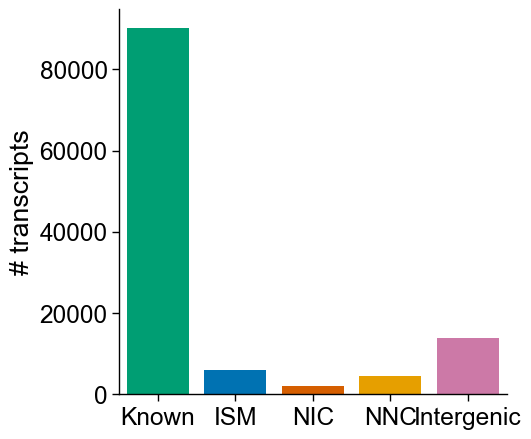

In [59]:
c_dict, order = get_talon_nov_colors(cats=df.novelty.unique().tolist())
init_plot_settings()
ax = sns.barplot(df, x='novelty', palette=c_dict, y='transcript_id', order=order, saturation=1)
xlabel = ''
ylabel = '# transcripts'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [60]:
df

,novelty,transcript_id
0,ISM,5954
1,Intergenic,13790
2,Known,90240
3,NIC,2008
4,NNC,4491
